Aligning 5311 spikes from 31 units across 6 trials...
✓ Saved plot to: results\figures\a2_brush_tail_CortexRaster.png


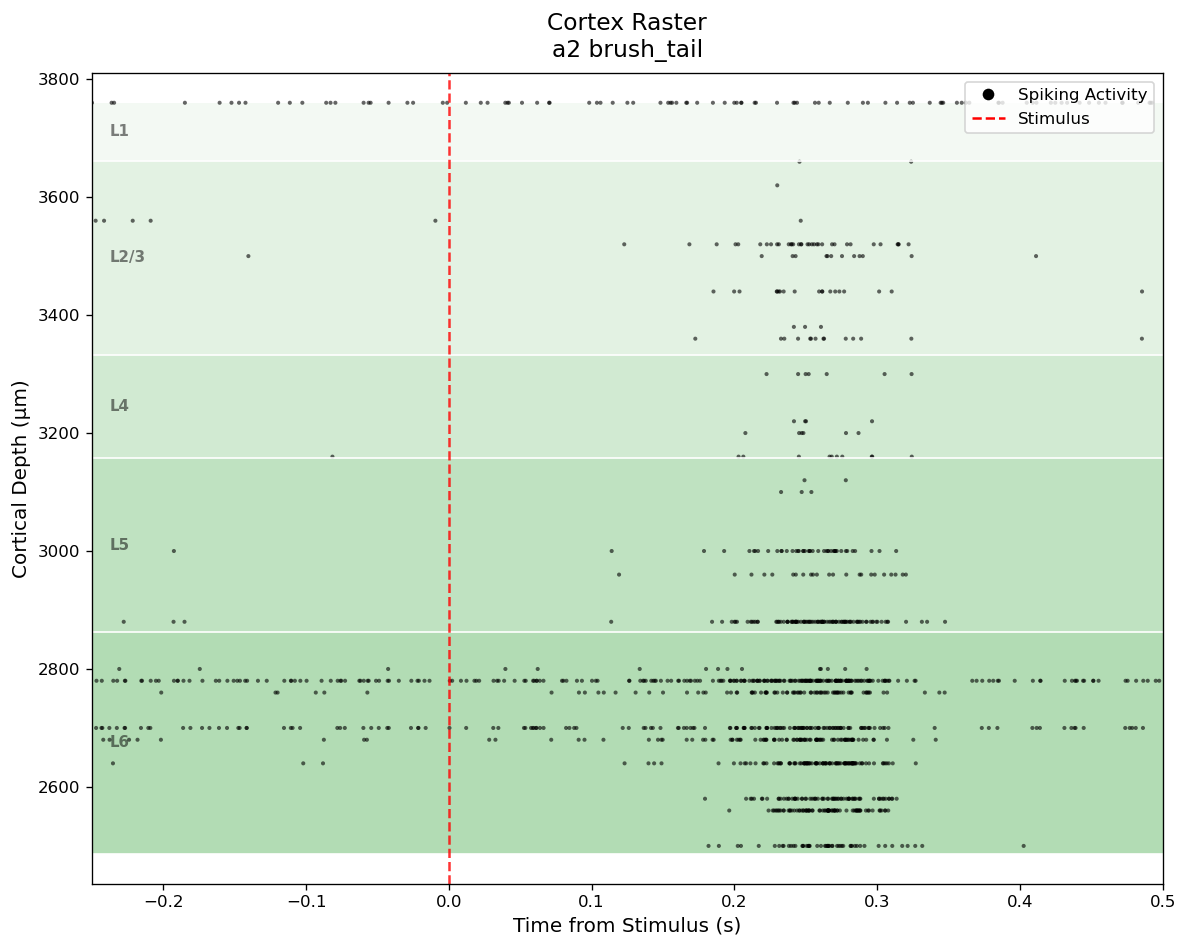

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# =========================================================
# 1. CONFIGURATION
# =========================================================
SESSION = "a2"           
STIM = "brush_tail"    
INCLUDE_MUA = True       

# Time Window
PRE_TIME = 0.25    # Seconds before stim
POST_TIME = 0.5   # Seconds after stim

# Colors 
LAYER_COLORS = {'L1': '#E8F5E9', 'L2/3': '#C8E6C9', 'L4': '#A5D6A7', 'L5': '#81C784', 'L6': '#66BB6A'}
C_SPIKE = 'black'  # Unified color for all spikes

# =========================================================
# 2. LOAD METADATA & ANATOMY
# =========================================================
csv_path = Path("data/sessions_local.csv") if Path("data/sessions_local.csv").exists() else Path("data/sessions.csv")
sessions = pd.read_csv(csv_path)
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())].iloc[0]

phy_dir = Path(row['phy_dir'])

# Anatomy/Layers
def get_val(r, col):
    return float(r[col]) if col in r and not pd.isna(r[col]) else np.nan

s1_upper = get_val(row, 's1_upper_um')
s1_lower = get_val(row, 's1_lower_um')

layers = {
    'L1':   get_val(row, 'l1_end'),
    'L2/3': get_val(row, 'l23_end'),
    'L4':   get_val(row, 'l4_end'),
    'L5':   get_val(row, 'l5_end'),
    'L6':   get_val(row, 'l6_end')
}

# =========================================================
# 3. LOAD SPIKES & STIM TIMES
# =========================================================
# A. Stimulus Times
stim_path = Path(f"results/summaries/{SESSION}_{STIM}_onsets.txt")
if not stim_path.exists():
    raise FileNotFoundError(f"❌ Stim file not found: {stim_path}")
stim_times = np.loadtxt(stim_path)

# B. Spikes
spike_times = np.load(phy_dir / 'spike_times.npy').flatten()
spike_clusters = np.load(phy_dir / 'spike_clusters.npy').flatten()
spike_fs = 30000.0

# C. Cluster Info
cluster_info = pd.read_csv(phy_dir / 'cluster_info.tsv', sep='\t')
if 'KSLabel' in cluster_info.columns:
    label_col = 'KSLabel' 
else:
    label_col = 'group'

# =========================================================
# 4. ALIGN SPIKES
# =========================================================
plot_data = [] 

valid_labels = ['good', 'mua'] if INCLUDE_MUA else ['good']

# Identify valid units in S1
s1_units = cluster_info[
    (cluster_info['depth'] >= s1_lower) & 
    (cluster_info['depth'] <= s1_upper) &
    (cluster_info[label_col].isin(valid_labels))
]

# Map Unit ID -> Depth
unit_depth_map = dict(zip(s1_units['cluster_id'], s1_units['depth']))

# Filter Spike Arrays to only S1 spikes
mask_s1_spikes = np.isin(spike_clusters, s1_units['cluster_id'])
s1_spike_times = spike_times[mask_s1_spikes] / spike_fs
s1_spike_ids   = spike_clusters[mask_s1_spikes]

print(f"Aligning {len(s1_spike_times)} spikes from {len(s1_units)} units across {len(stim_times)} trials...")

for t_stim in stim_times:
    t_start = t_stim - PRE_TIME
    t_end = t_stim + POST_TIME
    
    # Binary search for spikes in this window
    idx_start = np.searchsorted(s1_spike_times, t_start)
    idx_end = np.searchsorted(s1_spike_times, t_end)
    
    window_spikes = s1_spike_times[idx_start:idx_end]
    window_ids = s1_spike_ids[idx_start:idx_end]
    
    # Calculate relative time
    rel_times = window_spikes - t_stim
    
    # Get depths
    depths = [unit_depth_map[uid] for uid in window_ids]
    
    # Store
    plot_data.append(pd.DataFrame({
        'time': rel_times,
        'depth': depths
    }))

if not plot_data:
    raise ValueError("No spikes found in window.")

df_plot = pd.concat(plot_data)

# =========================================================
# 5. VISUALIZATION
# =========================================================
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)

# --- A. Draw Anatomy Background ---
current_top = s1_upper 
if not np.isnan(s1_upper) and not np.isnan(s1_lower):
    for layer_name in ['L1', 'L2/3', 'L4', 'L5', 'L6']:
        bot = layers[layer_name]
        if not np.isnan(bot):
            # Draw shaded band
            ax.axhspan(bot, current_top, color=LAYER_COLORS.get(layer_name, 'white'), alpha=0.5, lw=0)
            
            # Label
            mid = (current_top + bot) / 2
            ax.text(-PRE_TIME * 0.95, mid, layer_name, ha='left', va='center', 
                    fontsize=9, fontweight='bold', color='black', alpha=0.5)
            
            # White separator line
            ax.axhline(bot, color='white', linestyle='-', linewidth=1)
            current_top = bot

# --- B. Plot Spikes ---
# Uniform scatter plot
ax.scatter(df_plot['time'], df_plot['depth'], 
           c=C_SPIKE, s=6, alpha=0.6, edgecolors='none')

# --- C. Styling ---
ax.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.8, label='Stimulus Onset')
ax.set_ylim(s1_lower - 50, s1_upper + 50)
ax.set_xlim(-PRE_TIME, POST_TIME)

ax.set_xlabel("Time from Stimulus (s)", fontsize=12)
ax.set_ylabel("Cortical Depth (µm)", fontsize=12)
ax.set_title(f"Cortex Raster\n{SESSION} {STIM}", fontsize=14, pad=10)

# Simplified Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=C_SPIKE, label='Spiking Activity', markersize=8),
    Line2D([0], [0], color='red', linestyle='--', label='Stimulus')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()

# Save
save_path = Path("results/figures") / f"{SESSION}_{STIM}_CortexRaster.png"
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path, dpi=300)
print(f"✓ Saved plot to: {save_path}")

plt.show()

Loaded 3 stimulus onsets
Loaded 742 spikes
Processing 3 S1 units for raster...
Raster: 16 total spikes
Building heatmap...
Heatmap max: 17.0 Hz, robust max: 10.6 Hz


C:\Users\Ben\AppData\Local\Temp\ipykernel_30480\2080365396.py:338: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle



✅ Saved integrated visualization to: results\figures\pup2_pinch_ipsi_CortexMasterPlot.png


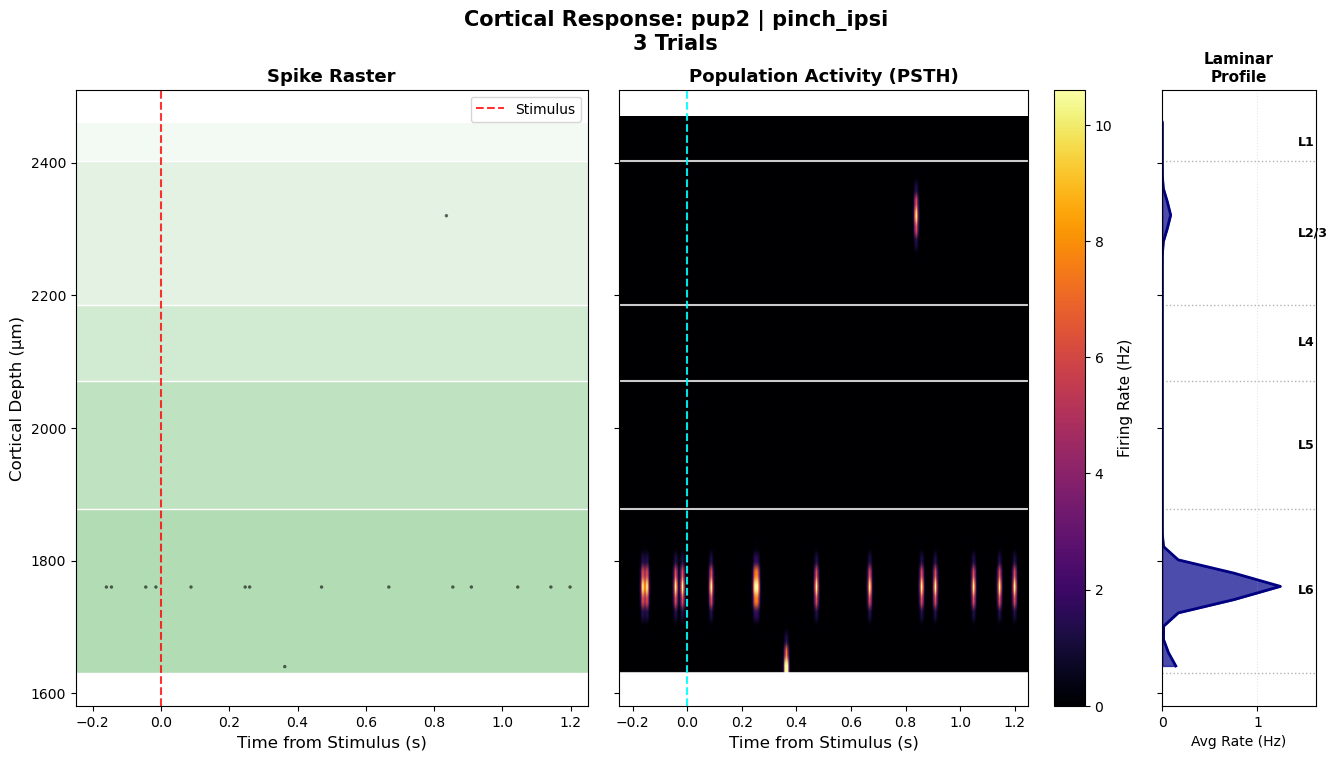

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.ndimage import gaussian_filter


# =========================================================
# 1. CONFIGURATION
# =========================================================
SESSION = "pup2"           
STIM = "pinch_ipsi"    
INCLUDE_MUA = True       


# Time Window
PRE_TIME = 0.25    # Seconds before stim
POST_TIME = 1.25    # Seconds after stim


# Heatmap Bins
BIN_TIME = 0.005   # 5ms time bins
BIN_DEPTH = 20     # 20µm depth bins


# Colors 
LAYER_COLORS = {
    'L1': '#E8F5E9', 
    'L2/3': '#C8E6C9', 
    'L4': '#A5D6A7', 
    'L5': '#81C784', 
    'L6': '#66BB6A'
}


# =========================================================
# 2. LOAD METADATA & ANATOMY
# =========================================================
csv_path = Path("data/sessions_local.csv") if Path("data/sessions_local.csv").exists() else Path("data/sessions.csv")
sessions = pd.read_csv(csv_path)
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())].iloc[0]


phy_dir = Path(row['phy_dir'])


# Helper function
def get_val(r, col):
    return float(r[col]) if col in r and not pd.isna(r[col]) else np.nan


s1_upper = get_val(row, 's1_upper_um')
s1_lower = get_val(row, 's1_lower_um')


layers = {
    'L1':   get_val(row, 'l1_end'),
    'L2/3': get_val(row, 'l23_end'),
    'L4':   get_val(row, 'l4_end'),
    'L5':   get_val(row, 'l5_end'),
    'L6':   get_val(row, 'l6_end')
}


# =========================================================
# 3. LOAD SPIKES & STIM TIMES
# =========================================================
# A. Stimulus Times
stim_path = Path(f"results/summaries/{SESSION}_{STIM}_onsets.txt")
if not stim_path.exists():
    raise FileNotFoundError(f"❌ Stim file not found: {stim_path}")
stim_times = np.loadtxt(stim_path)
if stim_times.ndim == 0: 
    stim_times = [stim_times]


# B. Spikes
spike_times = np.load(phy_dir / 'spike_times.npy').flatten()
spike_clusters = np.load(phy_dir / 'spike_clusters.npy').flatten()
spike_fs = 30000.0
spike_times_sec = spike_times / spike_fs


# C. Cluster Info
cluster_info = pd.read_csv(phy_dir / 'cluster_info.tsv', sep='\t')
label_col = 'KSLabel' if 'KSLabel' in cluster_info.columns else 'group'


# D. Templates for heatmap depth calculation
coords = np.load(phy_dir / 'channel_positions.npy')
templates = np.load(phy_dir / 'templates.npy')
spike_templates = np.load(phy_dir / 'spike_templates.npy').flatten()


print(f"Loaded {len(stim_times)} stimulus onsets")
print(f"Loaded {len(spike_times)} spikes")


# =========================================================
# 4. PREPARE RASTER DATA
# =========================================================
valid_labels = ['good', 'mua'] if INCLUDE_MUA else ['good']


# Identify valid units in S1
s1_units = cluster_info[
    (cluster_info['depth'] >= s1_lower) & 
    (cluster_info['depth'] <= s1_upper) &
    (cluster_info[label_col].isin(valid_labels))
]


# Map Unit ID -> Depth
unit_depth_map = dict(zip(s1_units['cluster_id'], s1_units['depth']))


# Filter Spike Arrays to only S1 spikes
mask_s1_spikes = np.isin(spike_clusters, s1_units['cluster_id'])
s1_spike_times = spike_times_sec[mask_s1_spikes]
s1_spike_ids = spike_clusters[mask_s1_spikes]


print(f"Processing {len(s1_units)} S1 units for raster...")


raster_data = []
for t_stim in stim_times:
    t_start = t_stim - PRE_TIME
    t_end = t_stim + POST_TIME
    
    idx_start = np.searchsorted(s1_spike_times, t_start)
    idx_end = np.searchsorted(s1_spike_times, t_end)
    
    window_spikes = s1_spike_times[idx_start:idx_end]
    window_ids = s1_spike_ids[idx_start:idx_end]
    
    rel_times = window_spikes - t_stim
    depths = [unit_depth_map[uid] for uid in window_ids]
    
    raster_data.append(pd.DataFrame({
        'time': rel_times,
        'depth': depths
    }))


df_raster = pd.concat(raster_data) if raster_data else pd.DataFrame()
print(f"Raster: {len(df_raster)} total spikes")


# =========================================================
# 5. PREPARE HEATMAP DATA
# =========================================================
print("Building heatmap...")


# Calculate spike depths from templates
template_peaks = np.max(np.abs(templates), axis=1) 
template_max_chans = np.argmax(template_peaks, axis=1)
all_spike_depths = coords[template_max_chans[spike_templates], 1]


# Filter to good/mua units for heatmap too
good_ids = set(s1_units['cluster_id'])
mask_good = np.isin(spike_clusters, list(good_ids))
spike_times_filtered = spike_times_sec[mask_good]
spike_depths_filtered = all_spike_depths[mask_good]


# Create bins
t_bins = np.arange(-PRE_TIME, POST_TIME + BIN_TIME, BIN_TIME)
d_bins = np.arange(s1_lower, s1_upper + BIN_DEPTH, BIN_DEPTH)


heatmap_2d = np.zeros((len(t_bins)-1, len(d_bins)-1))


for onset in stim_times:
    t_start, t_end = onset - PRE_TIME, onset + POST_TIME
    
    idx_start = np.searchsorted(spike_times_filtered, t_start)
    idx_end = np.searchsorted(spike_times_filtered, t_end)
    
    st_win = spike_times_filtered[idx_start:idx_end]
    sd_win = spike_depths_filtered[idx_start:idx_end]
    
    if len(st_win) == 0: 
        continue
    
    aligned_times = st_win - onset
    
    H, _, _ = np.histogram2d(aligned_times, sd_win, bins=[t_bins, d_bins])
    heatmap_2d += H


# Average and convert to Hz
heatmap_2d = (heatmap_2d / len(stim_times)) / BIN_TIME
heatmap_smooth = gaussian_filter(heatmap_2d, sigma=(1, 1))


# Calculate robust max
vmax = np.percentile(heatmap_smooth, 99.9)


print(f"Heatmap max: {np.max(heatmap_smooth):.1f} Hz, robust max: {vmax:.1f} Hz")


# =========================================================
# 6. PREPARE DEPTH PROFILE (time-averaged)
# =========================================================
depth_profile = np.mean(heatmap_smooth, axis=0)  # Average across time
depth_centers = (d_bins[:-1] + d_bins[1:]) / 2


# =========================================================
# 7. CREATE THREE-PANEL FIGURE
# =========================================================
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 0.6], wspace=0.08)


ax_raster = fig.add_subplot(gs[0])
ax_heatmap = fig.add_subplot(gs[1], sharey=ax_raster)
ax_profile = fig.add_subplot(gs[2], sharey=ax_raster)


# =========================================================
# 8. LEFT PANEL - RASTER
# =========================================================
# A. Draw layer bands
current_top = s1_upper
for layer_name in ['L1', 'L2/3', 'L4', 'L5', 'L6']:
    layer_bot = layers[layer_name]
    if not np.isnan(layer_bot):
        ax_raster.axhspan(layer_bot, current_top, 
                         color=LAYER_COLORS.get(layer_name, 'white'), 
                         alpha=0.5, lw=0)
        
        ax_raster.axhline(layer_bot, color='white', linestyle='-', linewidth=1)
        current_top = layer_bot


# B. Plot spikes
if len(df_raster) > 0:
    ax_raster.scatter(df_raster['time'], df_raster['depth'], 
                     c='black', s=6, alpha=0.6, edgecolors='none')


# C. Styling
ax_raster.axvline(0, color='red', linestyle='--', linewidth=1.5, 
                 alpha=0.8, label='Stimulus')
ax_raster.set_xlim(-PRE_TIME, POST_TIME)
ax_raster.set_ylim(s1_lower - 50, s1_upper + 50)
ax_raster.set_xlabel("Time from Stimulus (s)", fontsize=12)
ax_raster.set_ylabel("Cortical Depth (µm)", fontsize=12)
ax_raster.set_title("Spike Raster", fontsize=13, fontweight='bold')
ax_raster.legend(loc='upper right')


# =========================================================
# 9. MIDDLE PANEL - HEATMAP
# =========================================================
# A. Draw heatmap
im = ax_heatmap.imshow(heatmap_smooth.T, 
                       aspect='auto', 
                       cmap='inferno', 
                       origin='lower',
                       extent=[t_bins[0], t_bins[-1], d_bins[0], d_bins[-1]],
                       vmax=vmax)


# B. Colorbar
cbar = plt.colorbar(im, ax=ax_heatmap)
cbar.set_label("Firing Rate (Hz)", fontsize=11)


# C. Overlay layer lines (white)
for layer_name in ['L1', 'L2/3', 'L4', 'L5', 'L6']:
    layer_bot = layers[layer_name]
    if not np.isnan(layer_bot):
        ax_heatmap.axhline(layer_bot, color='white', 
                          linestyle='-', linewidth=1.5, alpha=0.8)


# D. Stimulus line
ax_heatmap.axvline(0, color='cyan', linestyle='--', linewidth=1.5, alpha=0.9)


# E. Styling
ax_heatmap.set_xlim(-PRE_TIME, POST_TIME)
ax_heatmap.set_xlabel("Time from Stimulus (s)", fontsize=12)
ax_heatmap.set_title("Population Activity (PSTH)", fontsize=13, fontweight='bold')
plt.setp(ax_heatmap.get_yticklabels(), visible=False)  # Hide Y labels


# =========================================================
# 10. RIGHT PANEL - DEPTH PROFILE
# =========================================================
# A. Layer boundaries
current_top = s1_upper
for layer_name in ['L1', 'L2/3', 'L4', 'L5', 'L6']:
    layer_bot = layers[layer_name]
    if not np.isnan(layer_bot):
        ax_profile.axhline(layer_bot, color='gray', 
                          linestyle=':', linewidth=1, alpha=0.6)
        
        # Layer labels
        layer_mid = (current_top + layer_bot) / 2
        ax_profile.text(np.max(depth_profile) * 1.15, layer_mid, 
                       layer_name, ha='left', va='center',
                       fontsize=9, fontweight='bold', color='black')
        current_top = layer_bot


# B. Plot profile
ax_profile.fill_betweenx(depth_centers, 0, depth_profile, 
                        color='darkblue', alpha=0.7)
ax_profile.plot(depth_profile, depth_centers, 
               color='navy', linewidth=2)


# C. Styling
ax_profile.set_xlim(0, np.max(depth_profile) * 1.3)
ax_profile.set_xlabel("Avg Rate (Hz)", fontsize=10)
ax_profile.set_title("Laminar\nProfile", fontsize=11, fontweight='bold')
ax_profile.grid(axis='x', alpha=0.3, linestyle=':')
plt.setp(ax_profile.get_yticklabels(), visible=False)


# =========================================================
# 11. FINALIZE
# =========================================================
fig.suptitle(f"Cortical Response: {SESSION} | {STIM}\n{len(stim_times)} Trials", 
            fontsize=15, fontweight='bold', y=0.98)


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle


# Save
save_path = Path("results/figures") / f"{SESSION}_{STIM}_CortexMasterPlot.png"
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Saved integrated visualization to: {save_path}")


plt.show()
